/tmp/ipython-input-2102893549.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✔ Data loaded for EURMAD=X

--- TRAINING MODEL ---
Epoch 1/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.0511 - val_loss: 0.0031
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0047 - val_loss: 0.0023
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - loss: 0.0025 - val_loss: 0.0020
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

RMSE (Test): 0.0516

--- BACKTEST RESULTS ---
       Metric    Value
 Total Trades      562
     Win Rate   57.30%
Profit Factor     1.53
    Total PnL     2.80
 Max Drawdown    -0.35
 Avg Duration 1440 min


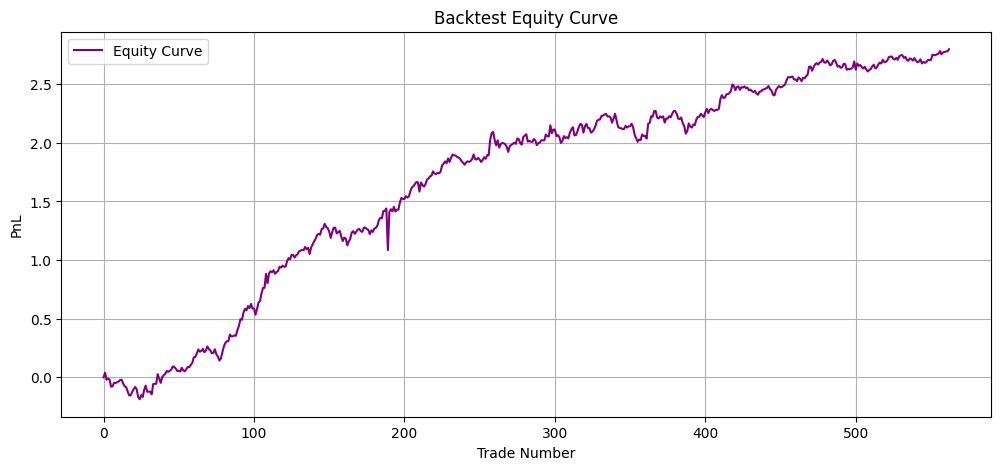

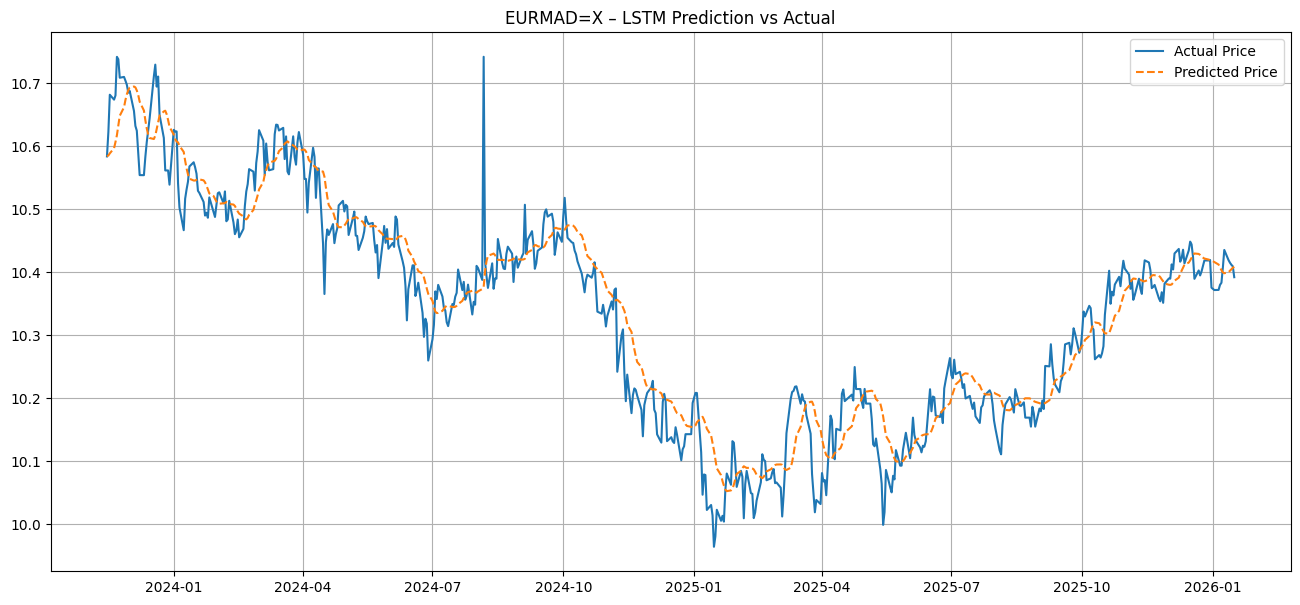

In [1]:
# ============================================================
# LSTM FORECASTING + REAL BACKTEST + PERFORMANCE METRICS
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


# 1. DATA LOADING (REAL DATA)

TICKER_SYMBOL = 'EURMAD=X'

try:
    data = yf.download(
        TICKER_SYMBOL,
        start='2015-01-01',
        end=pd.to_datetime('today').strftime('%Y-%m-%d')
    )

    df = data[['Close']].dropna()

    if df.empty:
        raise ValueError("No data received")

    prices = df['Close'].values
    print(f"✔ Data loaded for {TICKER_SYMBOL}")

except Exception as e:
    print("❌ Data error, switching to simulated data")

    np.random.seed(42)
    days = 1250
    t = np.arange(days)
    prices = 100 + 0.05 * t + np.sin(t / 100) * 5 + np.random.normal(0, 1.5, days)
    df = pd.DataFrame(
        {'Close': prices},
        index=pd.date_range(start='2020-01-01', periods=days, freq='B')
    )


# 2. PREPROCESSING

scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(prices.reshape(-1, 1))

TIME_STEP = 60

def create_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:i + time_step, 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

X, y = create_dataset(scaled_prices, TIME_STEP)
X = X.reshape(X.shape[0], X.shape[1], 1)

train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# 3. LSTM MODEL

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(TIME_STEP, 1)),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

print("\n--- TRAINING MODEL ---")
model.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1
)



# 4. PREDICTIONS

train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

train_pred = scaler.inverse_transform(train_pred)
test_pred = scaler.inverse_transform(test_pred)

y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

rmse = np.sqrt(mean_squared_error(y_test_real, test_pred.flatten()))
print(f"\nRMSE (Test): {rmse:.4f}")


# 5. SIGNAL GENERATION

signals = np.where(test_pred.flatten() > y_test_real, 1, -1)


# 6. BACKTEST ENGINE

trades = []
equity_curve = [0.0]

for i in range(len(signals) - 1):
    entry_price = y_test_real[i]
    exit_price = y_test_real[i + 1]

    pnl = signals[i] * (exit_price - entry_price)
    trades.append(pnl)
    equity_curve.append(equity_curve[-1] + pnl)

trades = np.array(trades)
equity_curve = np.array(equity_curve)


# 7. PERFORMANCE METRICS

total_trades = len(trades)
wins = trades[trades > 0]
losses = trades[trades < 0]

win_rate = (len(wins) / total_trades) * 100 if total_trades else 0
gross_profit = wins.sum()
gross_loss = abs(losses.sum())

profit_factor = gross_profit / gross_loss if gross_loss != 0 else np.inf
total_pnl = trades.sum()

peak = np.maximum.accumulate(equity_curve)
drawdown = equity_curve - peak
max_drawdown = drawdown.min()

avg_duration_min = 1440  # 1 day per trade

metrics = pd.DataFrame({
    "Metric": [
        "Total Trades",
        "Win Rate",
        "Profit Factor",
        "Total PnL",
        "Max Drawdown",
        "Avg Duration"
    ],
    "Value": [
        total_trades,
        f"{win_rate:.2f}%",
        f"{profit_factor:.2f}",
        f"{total_pnl:.2f}",
        f"{max_drawdown:.2f}",
        f"{avg_duration_min} min"
    ]
})

print("\n--- BACKTEST RESULTS ---")
print(metrics.to_string(index=False))


# 8. EQUITY CURVE


plt.figure(figsize=(12, 5))
plt.plot(equity_curve, color='purple', label='Equity Curve')
plt.title("Backtest Equity Curve")
plt.xlabel("Trade Number")
plt.ylabel("PnL")
plt.grid(True)
plt.legend()
plt.show()


# 9. PRICE + PREDICTIONS PLOT


plt.figure(figsize=(16, 7))
plt.plot(df.index[-len(y_test_real):], y_test_real, label='Actual Price')
plt.plot(df.index[-len(test_pred):], test_pred, label='Predicted Price', linestyle='--')
plt.legend()
plt.grid(True)
plt.title(f"{TICKER_SYMBOL} – LSTM Prediction vs Actual")
plt.show()

